In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import confusion_matrix, classification_report, \
    PrecisionRecallDisplay, RocCurveDisplay, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, AlphaDropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score,RocCurveDisplay


# UTILITIES

In [3]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def plot_scatter(X: 'reduced dataset', y: 'target variable',
                 class_names: dict = None, figsize = (6, 4), ax = None,
                 top_legend = True):
    '''
    class_names: dict mapping class numbers (y) to class names
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    scatter = ax.scatter(X[:, 0], X[:, 1], c = y, edgecolor = 'k', lw = 0.5)
    handles, labels = scatter.legend_elements()
    if class_names is not None:
        # each item in labels has the format '$\\mathdefault{number}$'
        keys = [int(''.join(filter(str.isdigit, string))) for string in labels]
        labels = [class_names[i] for i in keys]
    ax.set_xlabel('1st Component', fontsize = 14)
    ax.set_ylabel('2nd Component', fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])
    if top_legend:
        ax.legend(handles, labels, loc = 'lower center', ncol = 2,
                  fontsize = 'small', bbox_to_anchor = (0, 1, 1, 1))
    else:
        ax.legend(handles, labels, fontsize = 'small',
                  loc = 'center left',  bbox_to_anchor = (1.04, 0.5), borderaxespad = 0)

In [5]:
def report(results, n_top=3):
    df = pd.DataFrame()
    rank_names = []
    score_names = []
    for measure, values in results.items():
        if 'rank' == measure[:4]:
            rank_names.append(measure)
            score_name = measure[5:]
            score_names.append(score_name)
            df[measure] = values
    for score_name in score_names:
        df['mean_'+score_name] = results['mean_'+score_name]
        df['std_'+score_name] = results['std_'+score_name]
    df = pd.concat((df, pd.DataFrame(results['params'])), axis=1)
    df.sort_values(by=rank_names, inplace=True)
    df.index.name = 'model_idx'
    return df.head(n_top)

In [6]:
def plot_score(report:'cv_results_', score_name='score',
               legend_name=None, ax=None):
    if legend_name is None:
        legend_name = score_name
    if ax is None:
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot()

    # test score
    mean_val_score = report['mean_test_'+score_name]
    std_val_score = report['std_test_'+score_name]
    n = len(mean_val_score)
    x = range(n)
    ax.plot(x, mean_val_score, label='Validation set '+legend_name)
    ax.fill_between(x, mean_val_score - std_val_score,
                     mean_val_score + std_val_score, alpha = 0.2)

    # train score
    if 'mean_train_'+score_name in report:
        mean_train_score = report['mean_train_'+score_name]
        std_train_score = report['std_train_'+score_name]
        ax.plot(x, mean_train_score, label='Train set '+legend_name)
        ax.fill_between(x, mean_train_score - std_train_score,
                        mean_train_score + std_train_score,
                        alpha=0.2)
    return ax

In [7]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None,
                       figsize = (3,3), binary = False, ax=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16},
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
    return ax

In [8]:
def plot_multiclass_roc(clf, X, y, clf_name='', ax=None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        RocCurveDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f'class {label}', ax = ax)
    random = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--',
                 label = 'Random Classifier')
    ax.set_ylabel('True Positive Rate', fontsize = 14)
    ax.set_xlabel('False Positive Rate', fontsize = 14)
    return ax

In [9]:
def plot_multiclass_lift(clf, X, y, clf_name='', ax=None,
                          baseline = False):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    n_samples = X.shape[0]
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        idx = np.argsort(class_i_prob_arr)[::-1]
        acc = np.cumsum(class_i_arr[idx])
        perc_trues = acc / acc[-1]
        cum_samples = np.arange(1, n_samples + 1)
        perc_samples = cum_samples / n_samples
        lift = perc_trues / perc_samples
        ax.plot(lift, label = f'class {label}')
    if baseline:
        plt.axhline(y = 1, ls = '--', color = 'k')
    xticks = np.linspace(0, n_samples, 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    ax.set_xticks(xticks, x_lab)
    ax.set_xlabel('% of samples', fontsize = 14)
    ax.set_ylabel('Cumulative', fontsize = 14)
    return ax

In [10]:
def plot_multiclass_gain(clf, X, y, clf_name='', ax=None,
                          baseline = False):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    n_samples = X.shape[0]
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        idx = np.argsort(class_i_prob_arr)[::-1]
        acc = np.cumsum(class_i_arr[idx])
        ax.plot(acc, label = f'class {label}')
        if baseline:
            plt.plot([0,n_samples], [0, acc[-1]], 'k--', lw=0.75,alpha=1.)
    xticks = np.linspace(0, n_samples, 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    ax.set_xticks(xticks, x_lab)
    ax.set_xlabel('% of samples', fontsize = 14)
    ax.set_ylabel('Cumulative', fontsize = 14)
    return ax

In [11]:
def plot_multiclass_prec_rec(clf, X, y, clf_name='', ax=None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        PrecisionRecallDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f'class {label}', ax = ax),
        ax.axhline(y = (class_i_arr.sum() / y.size), ls = '--', lw=0.75, alpha=1.,
                        color = 'k')
    ax.set_ylabel('Precision', fontsize = 14)
    ax.set_xlabel('Recall', fontsize = 14)
    return ax

In [18]:
def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)

    return 2*((prec*rec)/(prec+rec+K.epsilon()))
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:

X_train = pd.read_csv('X_train_no_red.csv', header = 0)
y_train = pd.read_fwf('y_train.txt', header = None)
X_test = pd.read_csv('X_test_no_red.csv', header = 0)
y_test = pd.read_fwf('y_test.txt', header = None)

In [13]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)

In [14]:
with open("features.txt") as f:
    lines = f.read().splitlines()

In [15]:
features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [16]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

## DEEP NEURAL NETWORK

In [17]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l2
from keras import backend as K

In [19]:
n_classes = 6
def build_model():

    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam", metrics=['accuracy'])
    return model

In [20]:
def build_model_1(optimizer='SGD'):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(32, input_dim=n_feature, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    # Linear
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=[f1])
    return model

In [21]:
def build_model_2(optimizer='SGD'):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Linear
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=[f1])
    return model

In [22]:
def build_model_3(optimizer='SGD'):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(512, input_dim=n_feature, activation='tanh'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # Linear
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=[f1])
    return model

## MODEL 1

In [25]:
model1 = build_model_1()
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=10).history



Epoch 1/150
736/736 [==============================] - 4s 4ms/step - loss: 0.8382 - f1: 2.9954 - val_loss: 0.4665 - val_f1: 1.5120
Epoch 2/150
736/736 [==============================] - 2s 3ms/step - loss: 0.3252 - f1: 1.4098 - val_loss: 0.2737 - val_f1: 1.3896
Epoch 3/150
736/736 [==============================] - 2s 3ms/step - loss: 0.2402 - f1: 1.3187 - val_loss: 0.2847 - val_f1: 1.2840
Epoch 4/150
736/736 [==============================] - 2s 3ms/step - loss: 0.2006 - f1: 1.2534 - val_loss: 0.3180 - val_f1: 1.2307
Epoch 5/150
736/736 [==============================] - 4s 5ms/step - loss: 0.1747 - f1: 1.2150 - val_loss: 0.2530 - val_f1: 1.1717
Epoch 6/150
736/736 [==============================] - 2s 3ms/step - loss: 0.1511 - f1: 1.1751 - val_loss: 0.3329 - val_f1: 1.1480
Epoch 7/150
736/736 [==============================] - 2s 3ms/step - loss: 0.1416 - f1: 1.1424 - val_loss: 0.1648 - val_f1: 1.1503
Epoch 8/150
736/736 [==============================] - 2s 3ms/step - loss: 0.1274 -

In [27]:
model1 = KerasClassifier(build_fn=build_model_1)
model1.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=10)

<ipython-input-27-b1cc05791d37>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model1 = KerasClassifier(build_fn=build_model_1)


Epoch 1/300
589/589 [==============================] - 4s 3ms/step - loss: 0.8978 - f1: 2.6058 - val_loss: 0.5722 - val_f1: 1.4386
Epoch 2/300
589/589 [==============================] - 2s 4ms/step - loss: 0.3945 - f1: 1.3156 - val_loss: 0.6812 - val_f1: 0.9309
Epoch 3/300
589/589 [==============================] - 2s 3ms/step - loss: 0.2661 - f1: 1.1708 - val_loss: 0.8318 - val_f1: 0.9699
Epoch 4/300
589/589 [==============================] - 2s 3ms/step - loss: 0.2129 - f1: 1.0997 - val_loss: 0.2142 - val_f1: 1.0255
Epoch 5/300
589/589 [==============================] - 2s 3ms/step - loss: 0.1829 - f1: 1.0640 - val_loss: 0.2100 - val_f1: 1.0266
Epoch 6/300
589/589 [==============================] - 2s 3ms/step - loss: 0.1701 - f1: 1.0515 - val_loss: 0.1859 - val_f1: 0.9979
Epoch 7/300
589/589 [==============================] - 2s 3ms/step - loss: 0.1496 - f1: 1.0339 - val_loss: 0.2681 - val_f1: 0.9811
Epoch 8/300
589/589 [==============================] - 2s 3ms/step - loss: 0.1278 -

In [30]:
#model1 = KerasClassifier(build_fn=build_model_1)
#model1.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=10)

y_pred = model1.predict(X_test).astype(int)

y_scores = model1.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))

print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))

93/93 [==============================] - 0s 2ms/step
Accuracy 0.9372242958941296
F1-score [0.93398058 0.92946058 0.93532338 0.91648822 0.92902066 0.97616778]
              precision    recall  f1-score   support

           1       0.90      0.97      0.93       496
           2       0.91      0.95      0.93       471
           3       0.98      0.90      0.94       420
           4       0.97      0.87      0.92       491
           5       0.89      0.97      0.93       532
           6       1.00      0.95      0.98       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



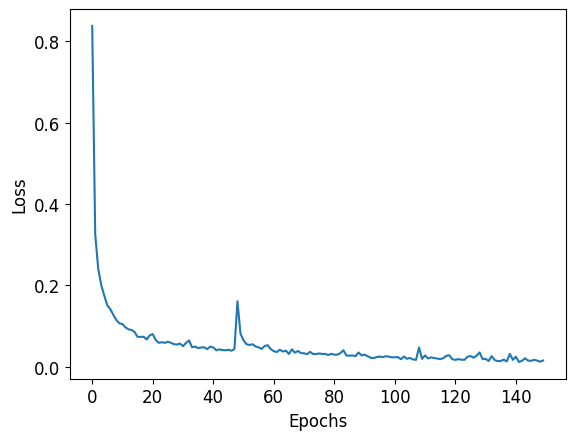

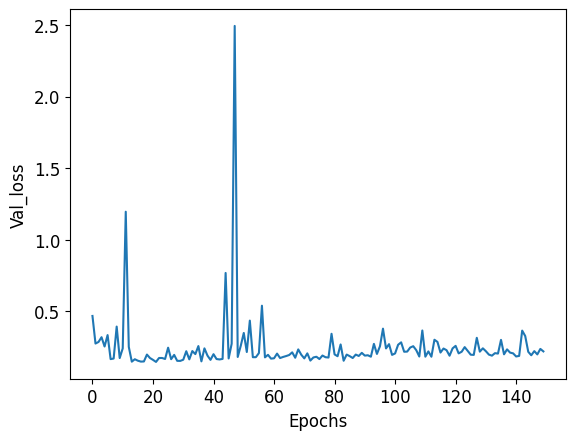

In [54]:
plt.plot(history1['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(history1['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Val_loss')
plt.show()

In [41]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))

AttributeError: ignored

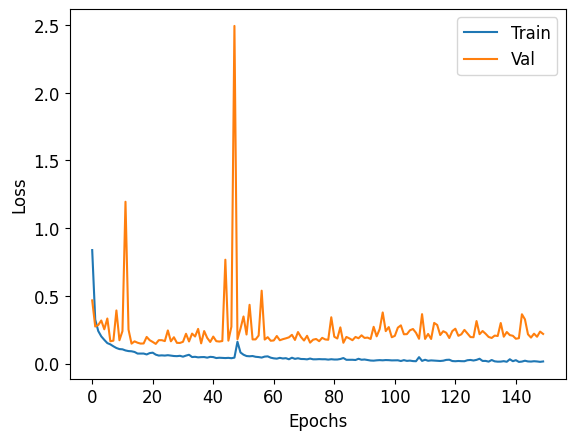

In [55]:
#history = clf.history_
plt.plot(history1['loss'], label='Train')
plt.plot(history1['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MODEL 2

In [ ]:
model2 = build_model_2()
history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=50).history


In [47]:
model2 = KerasClassifier(build_fn=build_model_2)
model2.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=50)

<ipython-input-47-8df8d6868eaf>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model2 = KerasClassifier(build_fn=build_model_2)


Epoch 1/150
118/118 [==============================] - 3s 17ms/step - loss: 1.3585 - f1: 4.6768 - val_loss: 0.9855 - val_f1: 4.3567
Epoch 2/150
118/118 [==============================] - 2s 14ms/step - loss: 0.8235 - f1: 2.8636 - val_loss: 0.6371 - val_f1: 1.7561
Epoch 3/150
118/118 [==============================] - 1s 5ms/step - loss: 0.5727 - f1: 1.5730 - val_loss: 0.5439 - val_f1: 1.4531
Epoch 4/150
118/118 [==============================] - 0s 4ms/step - loss: 0.4543 - f1: 1.3979 - val_loss: 0.3602 - val_f1: 1.3780
Epoch 5/150
118/118 [==============================] - 0s 4ms/step - loss: 0.3851 - f1: 1.3316 - val_loss: 0.3186 - val_f1: 1.2823
Epoch 6/150
118/118 [==============================] - 0s 4ms/step - loss: 0.3355 - f1: 1.2864 - val_loss: 0.2695 - val_f1: 1.2597
Epoch 7/150
118/118 [==============================] - 0s 4ms/step - loss: 0.3246 - f1: 1.2657 - val_loss: 0.3730 - val_f1: 1.1319
Epoch 8/150
118/118 [==============================] - 0s 4ms/step - loss: 0.2875

In [ ]:
history30 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=100).history

In [ ]:
plt.plot(history2['loss'], label='Loss 50 (batch_size)')
plt.plot(history30['loss'], label='Loss 100 (batch_size)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
y_pred = model2.predict(X_test).astype(int)

y_scores = model2.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))

print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred, target_names=activities.values()))

93/93 [==============================] - 0s 2ms/step
Accuracy 0.9412962334577536
F1-score [0.94527363 0.92763158 0.92450639 0.91789474 0.92968037 0.99533147]
              precision    recall  f1-score   support

           1       0.93      0.96      0.95       496
           2       0.96      0.90      0.93       471
           3       0.90      0.95      0.92       420
           4       0.95      0.89      0.92       491
           5       0.90      0.96      0.93       532
           6       1.00      0.99      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



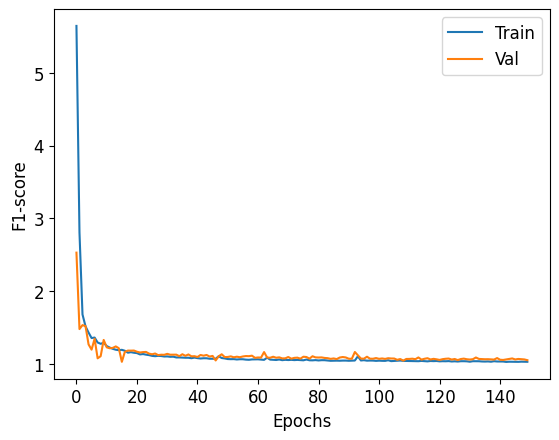

In [57]:
#history = clf.history_
plt.plot(history2['f1'], label='Train')
plt.plot(history2['val_f1'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()

In [ ]:
#history = clf.history_
plt.plot(history2['loss'], label='Train')
plt.plot(history2['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## MODEL 3

In [ ]:
model4 = build_model_3()
history4 = model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=50).history

In [24]:
model4 = KerasClassifier(build_fn=build_model_3)
model4.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=50)

<ipython-input-24-34de15553259>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model4 = KerasClassifier(build_fn=build_model_3)


Epoch 1/150
118/118 [==============================] - 2s 11ms/step - loss: 1.1412 - f1: 4.3040 - val_loss: 0.7238 - val_f1: 2.6878
Epoch 2/150
118/118 [==============================] - 1s 6ms/step - loss: 0.5964 - f1: 1.6210 - val_loss: 0.4858 - val_f1: 1.4335
Epoch 3/150
118/118 [==============================] - 1s 10ms/step - loss: 0.4320 - f1: 1.3663 - val_loss: 0.3618 - val_f1: 1.2561
Epoch 4/150
118/118 [==============================] - 1s 6ms/step - loss: 0.3768 - f1: 1.3169 - val_loss: 0.3010 - val_f1: 1.3011
Epoch 5/150
118/118 [==============================] - 1s 5ms/step - loss: 0.3094 - f1: 1.2697 - val_loss: 0.3186 - val_f1: 1.2257
Epoch 6/150
118/118 [==============================] - 1s 5ms/step - loss: 0.2578 - f1: 1.2205 - val_loss: 0.2255 - val_f1: 1.1529
Epoch 7/150
118/118 [==============================] - 1s 6ms/step - loss: 0.2411 - f1: 1.2006 - val_loss: 0.1990 - val_f1: 1.1926
Epoch 8/150
118/118 [==============================] - 1s 6ms/step - loss: 0.2081

In [25]:
y_pred = model4.predict(X_test).astype(int)

y_scores = model4.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))

print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))

93/93 [==============================] - 0s 2ms/step
Accuracy 0.9253478113335596
F1-score [0.92761905 0.91166848 0.94247246 0.88387824 0.90333618 0.98102467]
              precision    recall  f1-score   support

           1       0.88      0.98      0.93       496
           2       0.94      0.89      0.91       471
           3       0.97      0.92      0.94       420
           4       0.99      0.80      0.88       491
           5       0.83      0.99      0.90       532
           6       1.00      0.96      0.98       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



## EARLY STOPPING

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
es = EarlyStopping(monitor='val_accuracy', patience=50, verbose=True)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_accuracy', save_best_only=True)

In [29]:
clf = KerasClassifier(build_model_3, callbacks=[es, mc])

<ipython-input-29-53515d6a812b>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_model_3, callbacks=[es, mc])


In [30]:
clf.fit(X_train, y_train, validation_split=0.2, epochs=150)

Epoch 1/150
171/184 [==========================>...] - ETA: 0s - loss: 1.1482 - f1: 3.6963

184/184 [==============================] - 3s 7ms/step - loss: 1.1141 - f1: 3.5637 - val_loss: 0.5784 - val_f1: 1.6238
Epoch 2/150
175/184 [===========================>..] - ETA: 0s - loss: 0.4900 - f1: 1.4234

184/184 [==============================] - 1s 5ms/step - loss: 0.4829 - f1: 1.4171 - val_loss: 0.3392 - val_f1: 1.2370
Epoch 3/150
180/184 [============================>.] - ETA: 0s - loss: 0.3377 - f1: 1.2633

184/184 [==============================] - 1s 4ms/step - loss: 0.3361 - f1: 1.2628 - val_loss: 0.2392 - val_f1: 1.1869
Epoch 4/150
177/184 [===========================>..] - ETA: 0s - loss: 0.2731 - f1: 1.1954

184/184 [==============================] - 1s 4ms/step - loss: 0.2709 - f1: 1.1939 - val_loss: 0.2109 - val_f1: 1.1178
Epoch 5/150
182/184 [============================>.] - ETA: 0s - loss: 0.2375 - f1: 1.1521

184/184 [==============================] - 1s 4ms/step - loss: 0.2380 - f1: 1.1519 - val_loss: 0.2826 - val_f1: 1.0699
Epoch 6/150
182/184 [============================>.] - ETA: 0s - loss: 0.2028 - f1: 1.1189

184/184 [==============================] - 1s 4ms/step - loss: 0.2019 - f1: 1.1179 - val_loss: 0.2023 - val_f1: 1.0786
Epoch 7/150
171/184 [==========================>...] - ETA: 0s - loss: 0.1921 - f1: 1.1007

184/184 [==============================] - 1s 4ms/step - loss: 0.1878 - f1: 1.0976 - val_loss: 0.1616 - val_f1: 1.0370
Epoch 8/150
180/184 [============================>.] - ETA: 0s - loss: 0.1688 - f1: 1.0791

184/184 [==============================] - 1s 4ms/step - loss: 0.1696 - f1: 1.0792 - val_loss: 0.1968 - val_f1: 1.0957
Epoch 9/150
181/184 [============================>.] - ETA: 0s - loss: 0.1527 - f1: 1.0748

184/184 [==============================] - 1s 4ms/step - loss: 0.1539 - f1: 1.0760 - val_loss: 0.2056 - val_f1: 1.0749
Epoch 10/150
179/184 [============================>.] - ETA: 0s - loss: 0.1440 - f1: 1.0520

184/184 [==============================] - 1s 5ms/step - loss: 0.1427 - f1: 1.0531 - val_loss: 0.1371 - val_f1: 1.0054
Epoch 11/150
177/184 [===========================>..] - ETA: 0s - loss: 0.1267 - f1: 1.0316

184/184 [==============================] - 1s 6ms/step - loss: 0.1315 - f1: 1.0331 - val_loss: 0.1709 - val_f1: 1.0085
Epoch 12/150
181/184 [============================>.] - ETA: 0s - loss: 0.1245 - f1: 1.0309

184/184 [==============================] - 1s 6ms/step - loss: 0.1244 - f1: 1.0320 - val_loss: 0.2827 - val_f1: 1.0119
Epoch 13/150
173/184 [===========================>..] - ETA: 0s - loss: 0.1120 - f1: 1.0202

184/184 [==============================] - 1s 5ms/step - loss: 0.1107 - f1: 1.0192 - val_loss: 0.1952 - val_f1: 1.0166
Epoch 14/150
176/184 [===========================>..] - ETA: 0s - loss: 0.1181 - f1: 1.0156

184/184 [==============================] - 1s 4ms/step - loss: 0.1167 - f1: 1.0169 - val_loss: 0.1883 - val_f1: 0.9967
Epoch 15/150
178/184 [============================>.] - ETA: 0s - loss: 0.1102 - f1: 1.0192

184/184 [==============================] - 1s 4ms/step - loss: 0.1095 - f1: 1.0188 - val_loss: 0.1303 - val_f1: 0.9870
Epoch 16/150
175/184 [===========================>..] - ETA: 0s - loss: 0.1016 - f1: 1.0009

184/184 [==============================] - 1s 4ms/step - loss: 0.1029 - f1: 1.0030 - val_loss: 0.1231 - val_f1: 0.9752
Epoch 17/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0968 - f1: 1.0034

184/184 [==============================] - 1s 5ms/step - loss: 0.0956 - f1: 1.0013 - val_loss: 0.1825 - val_f1: 0.9692
Epoch 18/150
179/184 [============================>.] - ETA: 0s - loss: 0.0907 - f1: 0.9975

184/184 [==============================] - 1s 4ms/step - loss: 0.0924 - f1: 0.9988 - val_loss: 0.1476 - val_f1: 0.9616
Epoch 19/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0879 - f1: 0.9918

184/184 [==============================] - 1s 4ms/step - loss: 0.0867 - f1: 0.9898 - val_loss: 0.1313 - val_f1: 0.9548
Epoch 20/150
178/184 [============================>.] - ETA: 0s - loss: 0.0926 - f1: 0.9924

184/184 [==============================] - 1s 4ms/step - loss: 0.0913 - f1: 0.9927 - val_loss: 0.1659 - val_f1: 0.9621
Epoch 21/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0878 - f1: 0.9884

184/184 [==============================] - 1s 4ms/step - loss: 0.0902 - f1: 0.9886 - val_loss: 0.1282 - val_f1: 0.9646
Epoch 22/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0890 - f1: 0.9885

184/184 [==============================] - 1s 4ms/step - loss: 0.0869 - f1: 0.9870 - val_loss: 0.1285 - val_f1: 0.9568
Epoch 23/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0808 - f1: 0.9777

184/184 [==============================] - 1s 4ms/step - loss: 0.0790 - f1: 0.9764 - val_loss: 0.1259 - val_f1: 0.9619
Epoch 24/150
181/184 [============================>.] - ETA: 0s - loss: 0.0702 - f1: 0.9784

184/184 [==============================] - 1s 4ms/step - loss: 0.0698 - f1: 0.9783 - val_loss: 0.1626 - val_f1: 0.9517
Epoch 25/150
182/184 [============================>.] - ETA: 0s - loss: 0.0894 - f1: 0.9782

184/184 [==============================] - 1s 6ms/step - loss: 0.0889 - f1: 0.9777 - val_loss: 0.1181 - val_f1: 0.9531
Epoch 26/150
183/184 [============================>.] - ETA: 0s - loss: 0.0743 - f1: 0.9760

184/184 [==============================] - 1s 7ms/step - loss: 0.0740 - f1: 0.9753 - val_loss: 0.1092 - val_f1: 0.9562
Epoch 27/150
182/184 [============================>.] - ETA: 0s - loss: 0.0605 - f1: 0.9657

184/184 [==============================] - 1s 7ms/step - loss: 0.0606 - f1: 0.9662 - val_loss: 0.1517 - val_f1: 0.9500
Epoch 28/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0763 - f1: 0.9747

184/184 [==============================] - 1s 8ms/step - loss: 0.0750 - f1: 0.9750 - val_loss: 0.2361 - val_f1: 0.9644
Epoch 29/150
179/184 [============================>.] - ETA: 0s - loss: 0.0673 - f1: 0.9720

184/184 [==============================] - 1s 6ms/step - loss: 0.0663 - f1: 0.9720 - val_loss: 0.1163 - val_f1: 0.9439
Epoch 30/150
183/184 [============================>.] - ETA: 0s - loss: 0.0658 - f1: 0.9644

184/184 [==============================] - 1s 6ms/step - loss: 0.0660 - f1: 0.9648 - val_loss: 0.2551 - val_f1: 0.9599
Epoch 31/150
170/184 [==========================>...] - ETA: 0s - loss: 0.0614 - f1: 0.9675

184/184 [==============================] - 1s 5ms/step - loss: 0.0609 - f1: 0.9664 - val_loss: 0.1666 - val_f1: 0.9467
Epoch 32/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0636 - f1: 0.9613

184/184 [==============================] - 1s 5ms/step - loss: 0.0645 - f1: 0.9615 - val_loss: 0.1225 - val_f1: 0.9388
Epoch 33/150
179/184 [============================>.] - ETA: 0s - loss: 0.0626 - f1: 0.9638

184/184 [==============================] - 1s 5ms/step - loss: 0.0621 - f1: 0.9644 - val_loss: 0.1275 - val_f1: 0.9392
Epoch 34/150
183/184 [============================>.] - ETA: 0s - loss: 0.0553 - f1: 0.9559

184/184 [==============================] - 1s 5ms/step - loss: 0.0553 - f1: 0.9566 - val_loss: 0.1100 - val_f1: 0.9396
Epoch 35/150
175/184 [===========================>..] - ETA: 0s - loss: 0.0602 - f1: 0.9653

184/184 [==============================] - 1s 5ms/step - loss: 0.0606 - f1: 0.9650 - val_loss: 0.1050 - val_f1: 0.9385
Epoch 36/150
182/184 [============================>.] - ETA: 0s - loss: 0.0598 - f1: 0.9562

184/184 [==============================] - 1s 7ms/step - loss: 0.0624 - f1: 0.9567 - val_loss: 0.1549 - val_f1: 0.9436
Epoch 37/150
182/184 [============================>.] - ETA: 0s - loss: 0.0587 - f1: 0.9619

184/184 [==============================] - 2s 8ms/step - loss: 0.0583 - f1: 0.9612 - val_loss: 0.1101 - val_f1: 0.9378
Epoch 38/150
180/184 [============================>.] - ETA: 0s - loss: 0.0579 - f1: 0.9579

184/184 [==============================] - 2s 9ms/step - loss: 0.0575 - f1: 0.9575 - val_loss: 0.1137 - val_f1: 0.9439
Epoch 39/150
178/184 [============================>.] - ETA: 0s - loss: 0.0599 - f1: 0.9611

184/184 [==============================] - 1s 5ms/step - loss: 0.0587 - f1: 0.9600 - val_loss: 0.1216 - val_f1: 0.9375
Epoch 40/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0573 - f1: 0.9615

184/184 [==============================] - 1s 4ms/step - loss: 0.0566 - f1: 0.9608 - val_loss: 0.1091 - val_f1: 0.9358
Epoch 41/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0555 - f1: 0.9572

184/184 [==============================] - 1s 4ms/step - loss: 0.0553 - f1: 0.9574 - val_loss: 0.1139 - val_f1: 0.9341
Epoch 42/150
175/184 [===========================>..] - ETA: 0s - loss: 0.0506 - f1: 0.9545

184/184 [==============================] - 1s 4ms/step - loss: 0.0495 - f1: 0.9531 - val_loss: 0.1196 - val_f1: 0.9355
Epoch 43/150
175/184 [===========================>..] - ETA: 0s - loss: 0.0513 - f1: 0.9530

184/184 [==============================] - 1s 4ms/step - loss: 0.0512 - f1: 0.9526 - val_loss: 0.1212 - val_f1: 0.9365
Epoch 44/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0489 - f1: 0.9522

184/184 [==============================] - 1s 4ms/step - loss: 0.0487 - f1: 0.9518 - val_loss: 0.1086 - val_f1: 0.9344
Epoch 45/150
179/184 [============================>.] - ETA: 0s - loss: 0.0520 - f1: 0.9522

184/184 [==============================] - 1s 4ms/step - loss: 0.0532 - f1: 0.9535 - val_loss: 0.1385 - val_f1: 0.9558
Epoch 46/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0501 - f1: 0.9525

184/184 [==============================] - 1s 5ms/step - loss: 0.0494 - f1: 0.9520 - val_loss: 0.1103 - val_f1: 0.9324
Epoch 47/150
172/184 [===========================>..] - ETA: 0s - loss: 0.0449 - f1: 0.9509

184/184 [==============================] - 1s 4ms/step - loss: 0.0448 - f1: 0.9510 - val_loss: 0.1208 - val_f1: 0.9259
Epoch 48/150
182/184 [============================>.] - ETA: 0s - loss: 0.0436 - f1: 0.9494

184/184 [==============================] - 1s 4ms/step - loss: 0.0433 - f1: 0.9495 - val_loss: 0.1167 - val_f1: 0.9300
Epoch 49/150
170/184 [==========================>...] - ETA: 0s - loss: 0.0472 - f1: 0.9476

184/184 [==============================] - 1s 5ms/step - loss: 0.0466 - f1: 0.9477 - val_loss: 0.1499 - val_f1: 0.9266
Epoch 50/150
178/184 [============================>.] - ETA: 0s - loss: 0.0450 - f1: 0.9457

184/184 [==============================] - 1s 5ms/step - loss: 0.0446 - f1: 0.9451 - val_loss: 0.1700 - val_f1: 0.9407
Epoch 51/150
181/184 [============================>.] - ETA: 0s - loss: 0.0438 - f1: 0.9461

184/184 [==============================] - 1s 7ms/step - loss: 0.0433 - f1: 0.9459 - val_loss: 0.1182 - val_f1: 0.9232
Epoch 52/150
179/184 [============================>.] - ETA: 0s - loss: 0.0477 - f1: 0.9468

184/184 [==============================] - 1s 7ms/step - loss: 0.0475 - f1: 0.9467 - val_loss: 0.4048 - val_f1: 0.9405
Epoch 53/150
182/184 [============================>.] - ETA: 0s - loss: 0.0456 - f1: 0.9472

184/184 [==============================] - 2s 8ms/step - loss: 0.0458 - f1: 0.9479 - val_loss: 0.1339 - val_f1: 0.9341
Epoch 54/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0510 - f1: 0.9501

184/184 [==============================] - 2s 9ms/step - loss: 0.0510 - f1: 0.9511 - val_loss: 0.1080 - val_f1: 0.9290
Epoch 55/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0435 - f1: 0.9447

184/184 [==============================] - 1s 8ms/step - loss: 0.0432 - f1: 0.9453 - val_loss: 0.1228 - val_f1: 0.9324
Epoch 56/150
174/184 [===========================>..] - ETA: 0s - loss: 0.0454 - f1: 0.9491

184/184 [==============================] - 1s 4ms/step - loss: 0.0442 - f1: 0.9485 - val_loss: 0.1156 - val_f1: 0.9286
Epoch 57/150
178/184 [============================>.] - ETA: 0s - loss: 0.0441 - f1: 0.9468

184/184 [==============================] - 1s 4ms/step - loss: 0.0459 - f1: 0.9479 - val_loss: 0.1007 - val_f1: 0.9354
Epoch 58/150
180/184 [============================>.] - ETA: 0s - loss: 0.0396 - f1: 0.9448

184/184 [==============================] - 1s 4ms/step - loss: 0.0392 - f1: 0.9447 - val_loss: 0.2593 - val_f1: 0.9347
Epoch 59/150
172/184 [===========================>..] - ETA: 0s - loss: 0.0449 - f1: 0.9465

184/184 [==============================] - 1s 4ms/step - loss: 0.0445 - f1: 0.9466 - val_loss: 0.1070 - val_f1: 0.9290
Epoch 60/150
174/184 [===========================>..] - ETA: 0s - loss: 0.0378 - f1: 0.9420

184/184 [==============================] - 1s 5ms/step - loss: 0.0401 - f1: 0.9437 - val_loss: 0.1111 - val_f1: 0.9320
Epoch 61/150
172/184 [===========================>..] - ETA: 0s - loss: 0.0508 - f1: 0.9500

184/184 [==============================] - 1s 4ms/step - loss: 0.0492 - f1: 0.9497 - val_loss: 0.1144 - val_f1: 0.9341
Epoch 62/150
180/184 [============================>.] - ETA: 0s - loss: 0.0421 - f1: 0.9485

184/184 [==============================] - 1s 5ms/step - loss: 0.0416 - f1: 0.9484 - val_loss: 0.1167 - val_f1: 0.9286
Epoch 63/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0396 - f1: 0.9464

184/184 [==============================] - 1s 7ms/step - loss: 0.0386 - f1: 0.9459 - val_loss: 0.1086 - val_f1: 0.9263
Epoch 64/150
182/184 [============================>.] - ETA: 0s - loss: 0.0369 - f1: 0.9391

184/184 [==============================] - 1s 7ms/step - loss: 0.0374 - f1: 0.9396 - val_loss: 0.1562 - val_f1: 0.9449
Epoch 65/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0340 - f1: 0.9433

184/184 [==============================] - 1s 5ms/step - loss: 0.0376 - f1: 0.9435 - val_loss: 0.1116 - val_f1: 0.9279
Epoch 66/150
170/184 [==========================>...] - ETA: 0s - loss: 0.0364 - f1: 0.9412

184/184 [==============================] - 1s 4ms/step - loss: 0.0357 - f1: 0.9418 - val_loss: 0.1277 - val_f1: 0.9205
Epoch 67/150
172/184 [===========================>..] - ETA: 0s - loss: 0.0378 - f1: 0.9385

184/184 [==============================] - 1s 4ms/step - loss: 0.0390 - f1: 0.9384 - val_loss: 0.1680 - val_f1: 0.9341
Epoch 68/150
179/184 [============================>.] - ETA: 0s - loss: 0.0353 - f1: 0.9430

184/184 [==============================] - 1s 5ms/step - loss: 0.0347 - f1: 0.9424 - val_loss: 0.1261 - val_f1: 0.9191
Epoch 69/150
173/184 [===========================>..] - ETA: 0s - loss: 0.0536 - f1: 0.9506

184/184 [==============================] - 1s 5ms/step - loss: 0.0518 - f1: 0.9491 - val_loss: 0.1119 - val_f1: 0.9347
Epoch 70/150
183/184 [============================>.] - ETA: 0s - loss: 0.0359 - f1: 0.9436

184/184 [==============================] - 1s 5ms/step - loss: 0.0357 - f1: 0.9430 - val_loss: 0.1102 - val_f1: 0.9239
Epoch 71/150
184/184 [==============================] - ETA: 0s - loss: 0.0480 - f1: 0.9471

184/184 [==============================] - 1s 5ms/step - loss: 0.0480 - f1: 0.9471 - val_loss: 0.1186 - val_f1: 0.9245
Epoch 72/150
182/184 [============================>.] - ETA: 0s - loss: 0.0440 - f1: 0.9446

184/184 [==============================] - 1s 7ms/step - loss: 0.0437 - f1: 0.9425 - val_loss: 0.1160 - val_f1: 0.9225
Epoch 73/150
173/184 [===========================>..] - ETA: 0s - loss: 0.0414 - f1: 0.9442

184/184 [==============================] - 1s 7ms/step - loss: 0.0407 - f1: 0.9434 - val_loss: 0.1161 - val_f1: 0.9222
Epoch 74/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0441 - f1: 0.9407

184/184 [==============================] - 1s 4ms/step - loss: 0.0423 - f1: 0.9426 - val_loss: 0.1234 - val_f1: 0.9225
Epoch 75/150
179/184 [============================>.] - ETA: 0s - loss: 0.0364 - f1: 0.9410

184/184 [==============================] - 1s 5ms/step - loss: 0.0362 - f1: 0.9409 - val_loss: 0.1124 - val_f1: 0.9276
Epoch 76/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0421 - f1: 0.9444

184/184 [==============================] - 1s 7ms/step - loss: 0.0420 - f1: 0.9441 - val_loss: 0.1273 - val_f1: 0.9252
Epoch 77/150
180/184 [============================>.] - ETA: 0s - loss: 0.0327 - f1: 0.9418

184/184 [==============================] - 1s 7ms/step - loss: 0.0323 - f1: 0.9413 - val_loss: 0.1432 - val_f1: 0.9198
Epoch 78/150
184/184 [==============================] - ETA: 0s - loss: 0.0356 - f1: 0.9400

184/184 [==============================] - 1s 5ms/step - loss: 0.0356 - f1: 0.9400 - val_loss: 0.1090 - val_f1: 0.9218
Epoch 79/150
179/184 [============================>.] - ETA: 0s - loss: 0.0326 - f1: 0.9384

184/184 [==============================] - 1s 4ms/step - loss: 0.0439 - f1: 0.9413 - val_loss: 0.1009 - val_f1: 0.9653
Epoch 80/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0344 - f1: 0.9440

184/184 [==============================] - 1s 4ms/step - loss: 0.0345 - f1: 0.9429 - val_loss: 0.1161 - val_f1: 0.9229
Epoch 81/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0303 - f1: 0.9366

184/184 [==============================] - 1s 5ms/step - loss: 0.0303 - f1: 0.9378 - val_loss: 0.1231 - val_f1: 0.9198
Epoch 82/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0372 - f1: 0.9414

184/184 [==============================] - 1s 4ms/step - loss: 0.0367 - f1: 0.9412 - val_loss: 0.1057 - val_f1: 0.9218
Epoch 83/150
184/184 [==============================] - ETA: 0s - loss: 0.0326 - f1: 0.9389

184/184 [==============================] - 1s 5ms/step - loss: 0.0326 - f1: 0.9389 - val_loss: 0.1079 - val_f1: 0.9242
Epoch 84/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0314 - f1: 0.9368

184/184 [==============================] - 1s 4ms/step - loss: 0.0307 - f1: 0.9354 - val_loss: 0.1169 - val_f1: 0.9181
Epoch 85/150
182/184 [============================>.] - ETA: 0s - loss: 0.0357 - f1: 0.9414

184/184 [==============================] - 1s 5ms/step - loss: 0.0355 - f1: 0.9410 - val_loss: 0.1531 - val_f1: 0.9286
Epoch 86/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0289 - f1: 0.9363

184/184 [==============================] - 1s 5ms/step - loss: 0.0301 - f1: 0.9374 - val_loss: 0.1005 - val_f1: 0.9198
Epoch 87/150
171/184 [==========================>...] - ETA: 0s - loss: 0.1419 - f1: 0.9772

184/184 [==============================] - 1s 5ms/step - loss: 0.1354 - f1: 0.9775 - val_loss: 0.1668 - val_f1: 0.9621
Epoch 88/150
178/184 [============================>.] - ETA: 0s - loss: 0.0468 - f1: 0.9479

184/184 [==============================] - 1s 5ms/step - loss: 0.0459 - f1: 0.9482 - val_loss: 0.1925 - val_f1: 0.9175
Epoch 89/150
173/184 [===========================>..] - ETA: 0s - loss: 0.0356 - f1: 0.9404

184/184 [==============================] - 1s 4ms/step - loss: 0.0367 - f1: 0.9388 - val_loss: 0.1665 - val_f1: 0.9141
Epoch 90/150
180/184 [============================>.] - ETA: 0s - loss: 0.0394 - f1: 0.9391

184/184 [==============================] - 2s 8ms/step - loss: 0.0391 - f1: 0.9383 - val_loss: 0.1385 - val_f1: 0.9276
Epoch 91/150
182/184 [============================>.] - ETA: 0s - loss: 0.0303 - f1: 0.9343

184/184 [==============================] - 2s 9ms/step - loss: 0.0301 - f1: 0.9337 - val_loss: 0.1323 - val_f1: 0.9212
Epoch 92/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0255 - f1: 0.9333

184/184 [==============================] - 1s 6ms/step - loss: 0.0256 - f1: 0.9338 - val_loss: 0.1217 - val_f1: 0.9263
Epoch 93/150
173/184 [===========================>..] - ETA: 0s - loss: 0.0399 - f1: 0.9437

184/184 [==============================] - 1s 6ms/step - loss: 0.0382 - f1: 0.9415 - val_loss: 0.1377 - val_f1: 0.9225
Epoch 94/150
182/184 [============================>.] - ETA: 0s - loss: 0.0357 - f1: 0.9401

184/184 [==============================] - 1s 7ms/step - loss: 0.0354 - f1: 0.9399 - val_loss: 0.1167 - val_f1: 0.9215
Epoch 95/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0287 - f1: 0.9361

184/184 [==============================] - 1s 7ms/step - loss: 0.0292 - f1: 0.9363 - val_loss: 0.1144 - val_f1: 0.9205
Epoch 96/150
181/184 [============================>.] - ETA: 0s - loss: 0.0277 - f1: 0.9349

184/184 [==============================] - 1s 5ms/step - loss: 0.0277 - f1: 0.9349 - val_loss: 0.1437 - val_f1: 0.9259
Epoch 97/150
179/184 [============================>.] - ETA: 0s - loss: 0.0292 - f1: 0.9338

184/184 [==============================] - 1s 5ms/step - loss: 0.0289 - f1: 0.9342 - val_loss: 0.1367 - val_f1: 0.9191
Epoch 98/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0348 - f1: 0.9333

184/184 [==============================] - 1s 5ms/step - loss: 0.0341 - f1: 0.9324 - val_loss: 0.1213 - val_f1: 0.9223
Epoch 99/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0303 - f1: 0.9372

184/184 [==============================] - 1s 5ms/step - loss: 0.0301 - f1: 0.9368 - val_loss: 0.1472 - val_f1: 0.9202
Epoch 100/150
173/184 [===========================>..] - ETA: 0s - loss: 0.0364 - f1: 0.9405

184/184 [==============================] - 1s 5ms/step - loss: 0.0360 - f1: 0.9396 - val_loss: 0.1302 - val_f1: 0.9232
Epoch 101/150
178/184 [============================>.] - ETA: 0s - loss: 0.0297 - f1: 0.9350

184/184 [==============================] - 1s 6ms/step - loss: 0.0299 - f1: 0.9344 - val_loss: 0.1878 - val_f1: 0.9171
Epoch 102/150
179/184 [============================>.] - ETA: 0s - loss: 0.0262 - f1: 0.9347

184/184 [==============================] - 1s 7ms/step - loss: 0.0259 - f1: 0.9334 - val_loss: 0.1072 - val_f1: 0.9218
Epoch 103/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0335 - f1: 0.9355

184/184 [==============================] - 1s 7ms/step - loss: 0.0325 - f1: 0.9359 - val_loss: 0.1105 - val_f1: 0.9208
Epoch 104/150
180/184 [============================>.] - ETA: 0s - loss: 0.0239 - f1: 0.9294

184/184 [==============================] - 1s 4ms/step - loss: 0.0243 - f1: 0.9305 - val_loss: 0.1426 - val_f1: 0.9178
Epoch 105/150
179/184 [============================>.] - ETA: 0s - loss: 0.0265 - f1: 0.9309

184/184 [==============================] - 1s 4ms/step - loss: 0.0271 - f1: 0.9319 - val_loss: 0.1620 - val_f1: 0.9171
Epoch 106/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0229 - f1: 0.9338

184/184 [==============================] - 2s 10ms/step - loss: 0.0227 - f1: 0.9335 - val_loss: 0.1255 - val_f1: 0.9157
Epoch 107/150
182/184 [============================>.] - ETA: 0s - loss: 0.0244 - f1: 0.9320

184/184 [==============================] - 1s 5ms/step - loss: 0.0243 - f1: 0.9321 - val_loss: 0.1204 - val_f1: 0.9229
Epoch 108/150
175/184 [===========================>..] - ETA: 0s - loss: 0.0350 - f1: 0.9329

184/184 [==============================] - 1s 5ms/step - loss: 0.0340 - f1: 0.9331 - val_loss: 0.1239 - val_f1: 0.9229
Epoch 109/150
183/184 [============================>.] - ETA: 0s - loss: 0.0278 - f1: 0.9331

184/184 [==============================] - 1s 5ms/step - loss: 0.0277 - f1: 0.9331 - val_loss: 0.1191 - val_f1: 0.9198
Epoch 110/150
178/184 [============================>.] - ETA: 0s - loss: 0.0320 - f1: 0.9340

184/184 [==============================] - 1s 4ms/step - loss: 0.0316 - f1: 0.9338 - val_loss: 0.1274 - val_f1: 0.9242
Epoch 111/150
184/184 [==============================] - ETA: 0s - loss: 0.0235 - f1: 0.9297

184/184 [==============================] - 1s 4ms/step - loss: 0.0235 - f1: 0.9297 - val_loss: 0.1914 - val_f1: 0.9130
Epoch 112/150
171/184 [==========================>...] - ETA: 0s - loss: 0.0250 - f1: 0.9312

184/184 [==============================] - 1s 4ms/step - loss: 0.0243 - f1: 0.9302 - val_loss: 0.1164 - val_f1: 0.9164
Epoch 113/150
183/184 [============================>.] - ETA: 0s - loss: 0.0265 - f1: 0.9304

184/184 [==============================] - 1s 5ms/step - loss: 0.0265 - f1: 0.9304 - val_loss: 0.1519 - val_f1: 0.9157
Epoch 114/150
179/184 [============================>.] - ETA: 0s - loss: 0.0196 - f1: 0.9253

184/184 [==============================] - 1s 6ms/step - loss: 0.0201 - f1: 0.9260 - val_loss: 0.1194 - val_f1: 0.9177
Epoch 115/150
182/184 [============================>.] - ETA: 0s - loss: 0.0186 - f1: 0.9284

184/184 [==============================] - 1s 7ms/step - loss: 0.0187 - f1: 0.9285 - val_loss: 0.1598 - val_f1: 0.9147
Epoch 116/150
179/184 [============================>.] - ETA: 0s - loss: 0.0265 - f1: 0.9326

184/184 [==============================] - 1s 6ms/step - loss: 0.0260 - f1: 0.9326 - val_loss: 0.1257 - val_f1: 0.9171
Epoch 117/150
174/184 [===========================>..] - ETA: 0s - loss: 0.0203 - f1: 0.9260

184/184 [==============================] - 1s 4ms/step - loss: 0.0229 - f1: 0.9268 - val_loss: 0.7657 - val_f1: 0.9177
Epoch 118/150
184/184 [==============================] - ETA: 0s - loss: 0.0284 - f1: 0.9327

184/184 [==============================] - 1s 5ms/step - loss: 0.0284 - f1: 0.9327 - val_loss: 0.1048 - val_f1: 0.9191
Epoch 119/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0310 - f1: 0.9327

184/184 [==============================] - 1s 5ms/step - loss: 0.0304 - f1: 0.9328 - val_loss: 0.1574 - val_f1: 0.9211
Epoch 120/150
184/184 [==============================] - ETA: 0s - loss: 0.0205 - f1: 0.9279

184/184 [==============================] - 1s 5ms/step - loss: 0.0205 - f1: 0.9279 - val_loss: 0.1711 - val_f1: 0.9116
Epoch 121/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0284 - f1: 0.9318

184/184 [==============================] - 1s 5ms/step - loss: 0.0278 - f1: 0.9325 - val_loss: 0.1175 - val_f1: 0.9256
Epoch 122/150
184/184 [==============================] - ETA: 0s - loss: 0.0238 - f1: 0.9318

184/184 [==============================] - 1s 7ms/step - loss: 0.0238 - f1: 0.9318 - val_loss: 0.2069 - val_f1: 0.9144
Epoch 123/150
178/184 [============================>.] - ETA: 0s - loss: 0.0190 - f1: 0.9289

184/184 [==============================] - 1s 7ms/step - loss: 0.0188 - f1: 0.9287 - val_loss: 0.2072 - val_f1: 0.9096
Epoch 124/150
178/184 [============================>.] - ETA: 0s - loss: 0.0202 - f1: 0.9256

184/184 [==============================] - 2s 10ms/step - loss: 0.0199 - f1: 0.9256 - val_loss: 0.1390 - val_f1: 0.9137
Epoch 125/150
182/184 [============================>.] - ETA: 0s - loss: 0.0243 - f1: 0.9282

184/184 [==============================] - 2s 10ms/step - loss: 0.0243 - f1: 0.9276 - val_loss: 0.2234 - val_f1: 0.9123
Epoch 126/150
180/184 [============================>.] - ETA: 0s - loss: 0.0235 - f1: 0.9273

184/184 [==============================] - 3s 15ms/step - loss: 0.0239 - f1: 0.9276 - val_loss: 0.2255 - val_f1: 0.9123
Epoch 127/150
183/184 [============================>.] - ETA: 0s - loss: 0.0341 - f1: 0.9292

184/184 [==============================] - 2s 10ms/step - loss: 0.0340 - f1: 0.9293 - val_loss: 0.1256 - val_f1: 0.9239
Epoch 128/150
181/184 [============================>.] - ETA: 0s - loss: 0.0215 - f1: 0.9306

184/184 [==============================] - 2s 8ms/step - loss: 0.0212 - f1: 0.9298 - val_loss: 0.1313 - val_f1: 0.9195
Epoch 129/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0234 - f1: 0.9285

184/184 [==============================] - 1s 4ms/step - loss: 0.0227 - f1: 0.9278 - val_loss: 0.1400 - val_f1: 0.9127
Epoch 130/150
172/184 [===========================>..] - ETA: 0s - loss: 0.0226 - f1: 0.9308

184/184 [==============================] - 1s 5ms/step - loss: 0.0220 - f1: 0.9314 - val_loss: 0.2909 - val_f1: 0.9110
Epoch 131/150
178/184 [============================>.] - ETA: 0s - loss: 0.0208 - f1: 0.9276

184/184 [==============================] - 1s 5ms/step - loss: 0.0203 - f1: 0.9261 - val_loss: 0.1197 - val_f1: 0.9178
Epoch 132/150
183/184 [============================>.] - ETA: 0s - loss: 0.0201 - f1: 0.9269

184/184 [==============================] - 1s 7ms/step - loss: 0.0204 - f1: 0.9267 - val_loss: 0.1323 - val_f1: 0.9198
Epoch 133/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0275 - f1: 0.9286

184/184 [==============================] - 1s 8ms/step - loss: 0.0276 - f1: 0.9294 - val_loss: 0.1291 - val_f1: 0.9164
Epoch 134/150
184/184 [==============================] - ETA: 0s - loss: 0.0174 - f1: 0.9254

184/184 [==============================] - 2s 12ms/step - loss: 0.0174 - f1: 0.9254 - val_loss: 0.1451 - val_f1: 0.9157
Epoch 135/150
174/184 [===========================>..] - ETA: 0s - loss: 0.0232 - f1: 0.9284

184/184 [==============================] - 2s 11ms/step - loss: 0.0223 - f1: 0.9279 - val_loss: 0.1436 - val_f1: 0.9185
Epoch 136/150
180/184 [============================>.] - ETA: 0s - loss: 0.0210 - f1: 0.9244

184/184 [==============================] - 1s 5ms/step - loss: 0.0208 - f1: 0.9251 - val_loss: 0.1387 - val_f1: 0.9130
Epoch 137/150
177/184 [===========================>..] - ETA: 0s - loss: 0.0189 - f1: 0.9244

184/184 [==============================] - 1s 5ms/step - loss: 0.0189 - f1: 0.9246 - val_loss: 0.1274 - val_f1: 0.9168
Epoch 138/150
173/184 [===========================>..] - ETA: 0s - loss: 0.0163 - f1: 0.9250

184/184 [==============================] - 1s 5ms/step - loss: 0.0159 - f1: 0.9257 - val_loss: 0.1440 - val_f1: 0.9144
Epoch 139/150
179/184 [============================>.] - ETA: 0s - loss: 0.0280 - f1: 0.9274

184/184 [==============================] - 1s 5ms/step - loss: 0.0277 - f1: 0.9279 - val_loss: 0.1336 - val_f1: 0.9245
Epoch 140/150
174/184 [===========================>..] - ETA: 0s - loss: 0.0160 - f1: 0.9224

184/184 [==============================] - 1s 5ms/step - loss: 0.0161 - f1: 0.9225 - val_loss: 0.2630 - val_f1: 0.9252
Epoch 141/150
181/184 [============================>.] - ETA: 0s - loss: 0.0157 - f1: 0.9251

184/184 [==============================] - 1s 5ms/step - loss: 0.0159 - f1: 0.9249 - val_loss: 0.1191 - val_f1: 0.9171
Epoch 142/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0211 - f1: 0.9287

184/184 [==============================] - 1s 5ms/step - loss: 0.0213 - f1: 0.9270 - val_loss: 0.2761 - val_f1: 0.9327
Epoch 143/150
175/184 [===========================>..] - ETA: 0s - loss: 0.0161 - f1: 0.9247

184/184 [==============================] - 1s 5ms/step - loss: 0.0158 - f1: 0.9240 - val_loss: 0.1290 - val_f1: 0.9198
Epoch 144/150
182/184 [============================>.] - ETA: 0s - loss: 0.0258 - f1: 0.9274

184/184 [==============================] - 1s 5ms/step - loss: 0.0256 - f1: 0.9272 - val_loss: 0.1086 - val_f1: 0.9218
Epoch 145/150
179/184 [============================>.] - ETA: 0s - loss: 0.0183 - f1: 0.9227

184/184 [==============================] - 1s 4ms/step - loss: 0.0180 - f1: 0.9234 - val_loss: 0.1263 - val_f1: 0.9171
Epoch 146/150
176/184 [===========================>..] - ETA: 0s - loss: 0.0201 - f1: 0.9248

184/184 [==============================] - 1s 7ms/step - loss: 0.0199 - f1: 0.9248 - val_loss: 0.1236 - val_f1: 0.9188
Epoch 147/150
179/184 [============================>.] - ETA: 0s - loss: 0.0193 - f1: 0.9250

184/184 [==============================] - 2s 8ms/step - loss: 0.0189 - f1: 0.9247 - val_loss: 0.1697 - val_f1: 0.9093
Epoch 148/150
182/184 [============================>.] - ETA: 0s - loss: 0.0208 - f1: 0.9235

184/184 [==============================] - 1s 8ms/step - loss: 0.0206 - f1: 0.9229 - val_loss: 0.1338 - val_f1: 0.9178
Epoch 149/150
179/184 [============================>.] - ETA: 0s - loss: 0.0156 - f1: 0.9231

184/184 [==============================] - 1s 7ms/step - loss: 0.0154 - f1: 0.9238 - val_loss: 0.1225 - val_f1: 0.9109
Epoch 150/150
178/184 [============================>.] - ETA: 0s - loss: 0.0184 - f1: 0.9250

184/184 [==============================] - 1s 8ms/step - loss: 0.0190 - f1: 0.9252 - val_loss: 0.1338 - val_f1: 0.9127


In [33]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, target_names=activities.values()))

93/93 [==============================] - 0s 3ms/step
Accuracy 0.9317950458092976
F1-score [0.93762575 0.93275488 0.91841492 0.90769231 0.9100346  0.98102467]
                    precision    recall  f1-score   support

           WALKING       0.94      0.94      0.94       496
  WALKING_UPSTAIRS       0.95      0.91      0.93       471
WALKING_DOWNSTAIRS       0.90      0.94      0.92       420
           SITTING       0.99      0.84      0.91       491
          STANDING       0.84      0.99      0.91       532
            LAYING       1.00      0.96      0.98       537

          accuracy                           0.93      2947
         macro avg       0.94      0.93      0.93      2947
      weighted avg       0.94      0.93      0.93      2947



## DROP OUT

In [44]:
from keras.layers import Dropout
n_classes=6
def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=32
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.1))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(n_classes))

    #compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

CON EARLY STOPPING

In [45]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_accuracy', save_best_only=True)

DROPOUT_model = KerasClassifier(build_DROPOUT_model, callbacks=[es,mc])
DROPOUT_model.fit(X_train, y_train, validation_split=0.2, epochs=150)

Epoch 1/150


<ipython-input-45-246645df7ad3>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  DROPOUT_model = KerasClassifier(build_DROPOUT_model, callbacks=[es,mc])


184/184 [==============================] - 2s 4ms/step - loss: 2.0493 - accuracy: 0.1301 - val_loss: 1.7918 - val_accuracy: 0.0829
Epoch 2/150
184/184 [==============================] - 0s 3ms/step - loss: 1.7958 - accuracy: 0.1342 - val_loss: 1.7918 - val_accuracy: 0.1360
Epoch 3/150
184/184 [==============================] - 0s 3ms/step - loss: 1.7954 - accuracy: 0.1330 - val_loss: 1.7918 - val_accuracy: 0.1292
Epoch 4/150
184/184 [==============================] - 0s 2ms/step - loss: 1.7918 - accuracy: 0.1195 - val_loss: 1.7918 - val_accuracy: 0.1278
Epoch 5/150
184/184 [==============================] - 0s 3ms/step - loss: 1.7957 - accuracy: 0.1260 - val_loss: 1.7918 - val_accuracy: 0.1360
Epoch 6/150
184/184 [==============================] - 0s 3ms/step - loss: 1.7934 - accuracy: 0.1359 - val_loss: 1.7918 - val_accuracy: 0.1666
Epoch 7/150
184/184 [==============================] - 0s 3ms/step - loss: 1.7918 - accuracy: 0.1544 - val_loss: 1.7918 - val_accuracy: 0.1666
Epoch 8/150

In [46]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_accuracy', save_best_only=True)

DROPOUT_model = KerasClassifier(build_DROPOUT_model, callbacks=[es,mc])
DROPOUT_model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=50)

Epoch 1/150


<ipython-input-46-f640134c8518>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  DROPOUT_model = KerasClassifier(build_DROPOUT_model, callbacks=[es,mc])


118/118 [==============================] - 2s 5ms/step - loss: 4.5187 - accuracy: 0.2158 - val_loss: 1.7918 - val_accuracy: 0.1598
Epoch 2/150
118/118 [==============================] - 0s 4ms/step - loss: 1.7954 - accuracy: 0.2282 - val_loss: 1.7918 - val_accuracy: 0.1319
Epoch 3/150
118/118 [==============================] - 0s 4ms/step - loss: 1.7918 - accuracy: 0.2090 - val_loss: 1.7918 - val_accuracy: 0.1298
Epoch 4/150
118/118 [==============================] - 1s 4ms/step - loss: 1.7934 - accuracy: 0.2159 - val_loss: 1.7918 - val_accuracy: 0.3134
Epoch 5/150
118/118 [==============================] - 1s 5ms/step - loss: 1.7938 - accuracy: 0.2556 - val_loss: 1.7918 - val_accuracy: 0.3107
Epoch 6/150
118/118 [==============================] - 0s 4ms/step - loss: 1.7933 - accuracy: 0.2532 - val_loss: 1.7918 - val_accuracy: 0.3148
Epoch 7/150
118/118 [==============================] - 0s 3ms/step - loss: 1.7935 - accuracy: 0.2194 - val_loss: 1.7918 - val_accuracy: 0.1366
Epoch 8/150

In [53]:
y_pred = DROPOUT_model.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

93/93 [==============================] - 1s 4ms/step
Accuracy 0.14183915846623685
F1-score [0.         0.         0.24843982 0.         0.         0.        ]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       496
           2       0.00      0.00      0.00       471
           3       0.14      1.00      0.25       420
           4       0.00      0.00      0.00       491
           5       0.00      0.00      0.00       532
           6       0.00      0.00      0.00       537

    accuracy                           0.14      2947
   macro avg       0.02      0.17      0.04      2947
weighted avg       0.02      0.14      0.04      2947



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## L2 REGULARIZATION

In [50]:
from keras.regularizers import l2, l1
n_classes=6
def build_L2_model():
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=32
    model.add(Dense(h_dim, activation='relu',
                    input_shape=(n_feature,), kernel_regularizer=l2(0.001)))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dense(n_classes))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [52]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_accuracy', save_best_only=True)

L2_model = KerasClassifier(build_L2_model, callbacks=[es,mc])
L2_model.fit(X_train, y_train, validation_split=0.2, epochs=150)

<ipython-input-52-b966d41f0e80>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  L2_model = KerasClassifier(build_L2_model, callbacks=[es,mc])


Epoch 1/150
184/184 [==============================] - 4s 7ms/step - loss: 1.9524 - accuracy: 0.1989 - val_loss: 1.8438 - val_accuracy: 0.1801
Epoch 2/150
184/184 [==============================] - 1s 3ms/step - loss: 1.8415 - accuracy: 0.1782 - val_loss: 1.8394 - val_accuracy: 0.1795
Epoch 3/150
184/184 [==============================] - 0s 3ms/step - loss: 1.8378 - accuracy: 0.1799 - val_loss: 1.8363 - val_accuracy: 0.1815
Epoch 4/150
184/184 [==============================] - 0s 3ms/step - loss: 1.8350 - accuracy: 0.1823 - val_loss: 1.8337 - val_accuracy: 0.1835
Epoch 5/150
184/184 [==============================] - 1s 3ms/step - loss: 1.8325 - accuracy: 0.1845 - val_loss: 1.8314 - val_accuracy: 0.1842
Epoch 6/150
184/184 [==============================] - 0s 3ms/step - loss: 1.8302 - accuracy: 0.1864 - val_loss: 1.8291 - val_accuracy: 0.1849
Epoch 7/150
184/184 [==============================] - 0s 3ms/step - loss: 1.8281 - accuracy: 0.1891 - val_loss: 1.8270 - val_accuracy: 0.1856

In [54]:
y_pred = L2_model.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, target_names=activities.values()))

93/93 [==============================] - 0s 3ms/step
Accuracy 0.15982354937224297
F1-score [0.         0.27559977 0.         0.         0.         0.        ]
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00       496
  WALKING_UPSTAIRS       0.16      1.00      0.28       471
WALKING_DOWNSTAIRS       0.00      0.00      0.00       420
           SITTING       0.00      0.00      0.00       491
          STANDING       0.00      0.00      0.00       532
            LAYING       0.00      0.00      0.00       537

          accuracy                           0.16      2947
         macro avg       0.03      0.17      0.05      2947
      weighted avg       0.03      0.16      0.04      2947



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
